In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from datetime import timedelta 
import datetime
from matplotlib.colors import rgb2hex
import os
import numpy as np
import seaborn as sns; sns.set()
from pyecharts.charts import Bar, Pie, Map, WordCloud, Geo
from pyecharts import options as opts
from pyecharts.globals import ChartType, SymbolType
from snapshot_selenium import snapshot
from pyecharts.render import make_snapshot
from __future__ import unicode_literals
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
from pyecharts.commons.utils import JsCode
import plotly.figure_factory as ff # map of the US
import plotly.graph_objects as go
import yfinance as yf # stock market
import us
from itertools import compress
import itertools
import import_ipynb
from utils_common import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [163]:
# State level data of COVID-19
# https://github.com/nytimes/covid-19-data/blob/master/us-states.csv
_NYT_DATA_FILE_ = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'

# County level data of COVID-19
# https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv
_NYT_DATA_County_FILE_ = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

# Rural-Urban Continuum Codes
# https://www.ers.usda.gov/data-products/rural-urban-continuum-codes/
_UR_FILE_xls_ = './data_US/ruralurbancodes2013.xls'
# https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/
_UR_FILE_csv_ = './data_US/co-est2019-alldata.csv'

# Where to save the dataframes and figures
_Data_PATH_ = './data_US/'
_Figure_PATH_ = './figures_US/'

In [164]:
# Calculate new confirmed, new dead, and new cured
def add_daily_new(df, group_keys=['state_name', 'county_name']):
    cols = ['confirmed', 'dead']
    daily_new = df.groupby(group_keys).agg(dict([(n, 'diff') for n in ['cum_' + c for c in cols]]))
    daily_new = daily_new.rename(columns=dict([('cum_' + n, 'new_' + n) for n in cols]))
    df = pd.concat([df, daily_new], axis=1, join='outer')
    return df

# Load data of COVID-19 
def load_NYT_raw():
    '''
    This provides a way to lookinto the 'raw' data
    '''
    raw = pd.read_csv(_NYT_DATA_FILE_)
    rename_dict = {'date': 'update_date',
                   'state': 'state_name',
                   'fips': 'fips',
                   'cases': 'cum_confirmed',
                   'deaths': 'cum_dead',
                  }
    data = raw.rename(columns=rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'])  # original type of update_time after read_csv is 'str'
    data['update_date'] = data['update_date'].dt.date
    data = add_daily_new(data, group_keys = ['state_name'])
    data = data.sort_values(['update_date', 'state_name'])
    data = data.reset_index(drop=True)
    print('Data date range: ', data['update_date'].min(), 'to', data['update_date'].max())
    print('Number of rows in raw data: ', data.shape[0])
    return data

def load_NYT_county_raw():
    '''
    This provides a way to lookinto the 'raw' data
    '''
    raw = pd.read_csv(_NYT_DATA_County_FILE_)
    rename_dict = {'date': 'update_date',
                   'county': 'county_name',
                   'state': 'state_name',
                   'fips': 'fips',
                   'cases': 'cum_confirmed',
                   'deaths': 'cum_dead',
                  }
    data = raw.rename(columns=rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'])  # original type of update_time after read_csv is 'str'
    data['update_date'] = data['update_date'].dt.date
    data = add_daily_new(data, group_keys = ['state_name', 'county_name'])
    data = data.sort_values(['update_date', 'state_name', 'county_name'])
    data = data.reset_index(drop=True)
    print('Data date range: ', data['update_date'].min(), 'to', data['update_date'].max())
    print('Number of rows in raw data: ', data.shape[0])
    return data

In [165]:
data_state = load_NYT_raw()

Data date range:  2020-01-21 to 2020-04-21
Number of rows in raw data:  2777


In [166]:
data_county = load_NYT_county_raw()

Data date range:  2020-01-21 to 2020-04-21
Number of rows in raw data:  78548


In [167]:
data_state.to_csv(_Data_PATH_ + 'data_NYT_state.csv', index = False)
data_county.to_csv(_Data_PATH_ + 'data_NYT_county.csv', index = False)

In [168]:
# Number of counties that have infected cases so far
fips_infection = list(set(data_county.fips))
fips_infection += [293800, 36061] # add the fips for New York City and Kansas City
fips_infection.sort()
fips_infection = [int(x) for x in fips_infection if str(x) != 'nan']
len(fips_infection)

2773

In [169]:
# Number of counties that do not have infected cases so far
data_UR[~data_UR['FIPS'].isin(fips_infection)].shape[0]

450

In [170]:
# Is Grafton County (in NH) an Urbanized Area or an Urban Cluster or a Rural Area?
data_UR = pd.read_excel(_UR_FILE_xls_)
data_UR[data_UR['County_Name'] == 'Grafton County']

FIPS State     County_Name  Population_2010  RUCC_2013  \
1768  33009    NH  Grafton County            89118          5   

                                            Description  
1768  Nonmetro - Urban population of 20,000 or more,...

In [171]:
def figure_ur(df, subject, fsize = (10,12), fs = 16, title = None, country = 'US'):

    def urban_rural(n):
        if n>= 100000:
            return 'Urbanized Area A'
        elif n >= 50000:
            return 'Urbanized Area B'
        elif n >= 2500:
            return 'Urban Cluster'
        else:
            return 'Rural'
    df = data_county.copy()
    df.at[df.index[df['county_name'] == 'Kansas City'].tolist(), 'fips'] = 293800
    df.at[df.index[df['county_name'] == 'New York City'].tolist(), 'fips'] = 36061
    df = df[(df['county_name']!='Unknown') & (df['county_name']!='Kansas City')].copy()
    df = df[df['state_name'].isin(names_state)]
    df = df[df['fips'].isin(list(set(data_UR['FIPS'])))]
    df = df.reset_index(drop = True)
    df['population'] = df.apply(lambda row: data_UR[data_UR['FIPS'] == row.fips]['Population_2010'].tolist()[0], axis=1)
    df['type'] = df.apply(lambda row: urban_rural(row.population), axis=1)
    df = df.groupby(['update_date','type'])['cum_confirmed', 'population'].apply(lambda x : x.sum()).reset_index()
    df['cum_confirmed%'] = df.apply(lambda row: row.cum_confirmed/row.population*100, axis=1)

    ur_list = ['Urbanized Area A', 'Urbanized Area B', 'Urban Cluster', 'Rural']
    ur_title_list = ['Urbanized Area', 'Urbanized Area', 'Urban Cluster', 'Rural']
    pop_list = [r'$n \geq 100,000$', r'$50,000 \leq n < 100,000$', r'$2,500 \leq n < 50,000$', r'$n < 2,500$']
    color_list = ['#E385A9', '#F5D1BE', '#AEDADE']
    color_list = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    fig, axes = plt.subplots(4, 1, figsize = fsize, sharey = False, sharex = True)
    sns.set_style("whitegrid")
    suffix = (lambda x: "" if x[-1] != '%' else "%")(subject)    
    
    for i, ur in enumerate(ur_list):
        ix = np.unravel_index(i, axes.shape)
        ax = axes[ix]
        df_single = df[df['type'] == ur].reset_index(drop = True)
        
        
        ax.plot(df_single['update_date'], df_single['cum_confirmed' + suffix], 
                        linewidth = 3, color = color_list[i], label = ur)
        ax.fill_between(df_single['update_date'], df_single['cum_confirmed' + suffix], 
                        color = color_list[i], label = None)
        if i == len(ur_list) - 1:
            ax.set_xlabel('Date', fontsize = fs - 2)
        if subject == 'R':
            ax.set_ylabel('Number of infected', fontsize = fs - 2)
        else:
            ax.set_ylabel('Percentage of infected', fontsize = fs - 2)
        
        ax.set_xlim(min(df.update_date), max(df.update_date))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

        ax.set_title(ur_title_list[i] + ': ' + pop_list[i], fontsize = fs) 
    if subject == 'conf':
        fig.suptitle(title + ': urban and rural', fontsize = fs + 2, y = 0.95)   
    else:
        fig.suptitle(title + ': urban and rural %', fontsize = fs + 2, y = 0.95)  
    fig.align_ylabels(axes[0:])
    fig.subplots_adjust(hspace = 0.3, wspace = 0)
    
    fig.savefig(_Figure_PATH_ + country + '_UR_' + subject.replace("%", "_percentage") + '.png', dpi = 400, bbox_inches='tight')

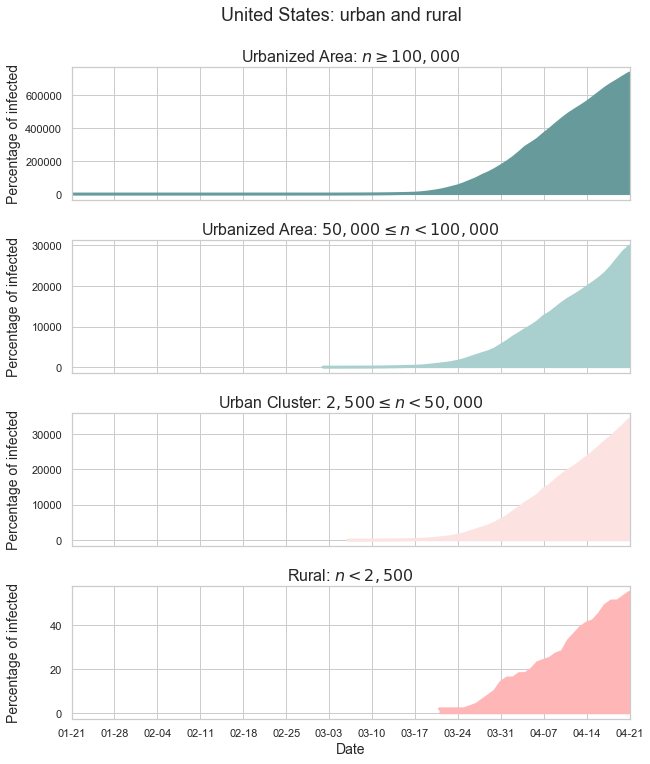

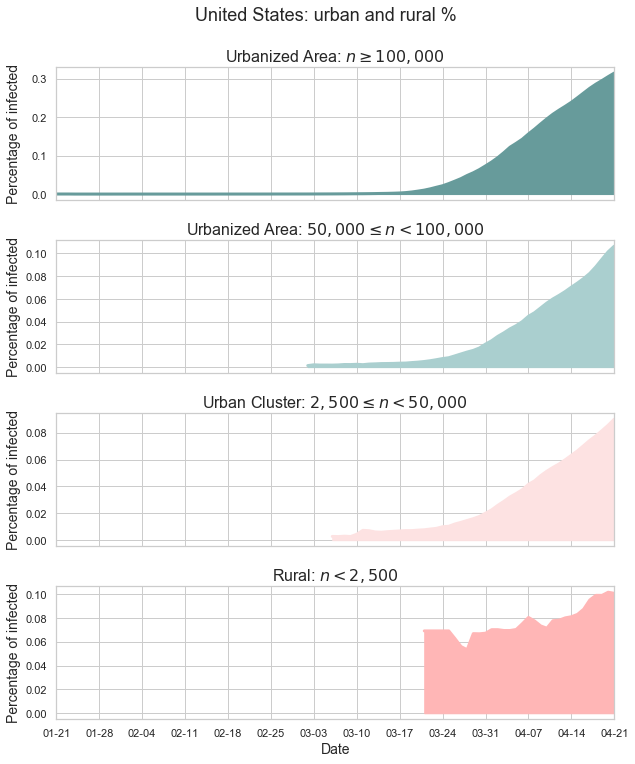

In [173]:
# % stands for percentage
figure_ur(data_county, 'conf', fsize = (10,12), fs = 16, title = 'United States', country = 'US')
figure_ur(data_county, 'conf%', fsize = (10,12), fs = 16, title = 'United States', country = 'US')

In [181]:
# Oversea territories
names_state_more = sorted(set(data_state['state_name']))
# American Samoa is an unincorporated territory of the United States located in the South Pacific Ocean.
# Guam is a U.S. island territory in Micronesia, in the Western Pacific. 
# Puerto Rico is a Caribbean island and unincorporated U.S. territory.
# The U.S. Virgin Islands are a group of Caribbean islands and islets.
# The Northern Mariana Islands are a U.S. commonwealth in the Pacific Ocean.
[item for item in names_state_more if item not in names_state]

['American Samoa',
 'Guam',
 'Northern Mariana Islands',
 'Puerto Rico',
 'Virgin Islands']

In [182]:
# Plot the confirmed cases for every state
def figure_conf_all(df, names_state, fsize = (5,3), ncol = 4, ms = 2, fs = 10, logy = False, 
                    title = None, country = 'US', pvi = False):
    
    sns.set_style("ticks")
    palette = plt.get_cmap('magma')
    
    m = len(names_state)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
            
    for i, state in enumerate(names_state):
        
        if pvi == True:
            c = color_pvi(df_state_pvi, state)
        else:
            c = palette(i/100 + 0.2)
        
        ix = np.unravel_index(i, axes.shape)
        
        plot_df = df[df['state_name'] == state]
        
        axes[ix].plot(plot_df['update_date'], plot_df['cum_confirmed'],
                linewidth = 2, marker = 'o', ms = ms, color = c, label = (lambda x: None if x > 0 else 'cum_confirmed')(i)) # 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Number of people (cum)', fontsize = fs - 2)
        if i == 0:
            axes[ix].legend(loc = 'upper left', fancybox = True, fontsize = fs - 4)
        axes[ix].set_title(state, fontsize = fs)
        
    fig.align_ylabels(axes[:, 0])
    
    for i, state in enumerate(names_state):   
        if pvi == True:
            c = color_pvi(df_state_pvi, state)
        else:
            c = palette(i/100 + 0.2)
        ix = np.unravel_index(i, axes.shape)
        plot_df = df[df['state_name'] == state]
        ax11 = axes[ix].twinx()
        
        ax11.grid(False) # hide grid lines
        ax11.bar(plot_df['update_date'], height = plot_df['new_confirmed'], color = c, alpha = 0.8,
                label = (lambda x: None if x > 0 else 'new_confirmed')(i))
        daily_patch = mpatches.Patch(color = c, label='new_confirmed')
        if i == 0:
            ax11.legend(handles=[daily_patch], loc='upper left', bbox_to_anchor=(0, 0.86), fancybox=True, fontsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
        if i % ncol == ncol - 1:
            ax11.set_ylabel('Number of people (new)', fontsize = fs - 2)
        
        axes[ix].set_xlim(min(df.update_date), max(df.update_date))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    fig.suptitle(title, fontsize = fs + 4, y = 0.915)
    
    if pvi == True:
        
        ix = np.unravel_index(int(ncol/2), axes.shape)
        palette_D = plt.get_cmap('Blues')
        palette_R = plt.get_cmap('Reds')
        palette_Even = plt.get_cmap('Greens')
        palette_None = plt.get_cmap('Purples')
        patch_D = mpatches.Patch(color = palette_D(0.6), label = 'Democratic')
        patch_R = mpatches.Patch(color = palette_R(0.6), label = 'Republican')
        patch_Even = mpatches.Patch(color = palette_Even(0.6), label = 'Even')
        patch_None = mpatches.Patch(color = palette_None(0.6), label = 'None')

        axes[ix].legend(handles = [patch_D, patch_R, patch_Even], loc = 'upper left', 
                   ncol = 4, bbox_to_anchor=(-0.65, 1.55), fontsize = fs, fancybox=True)
    

    fig.savefig(_Figure_PATH_ + country + '_conf.png', dpi = 400, bbox_inches='tight')

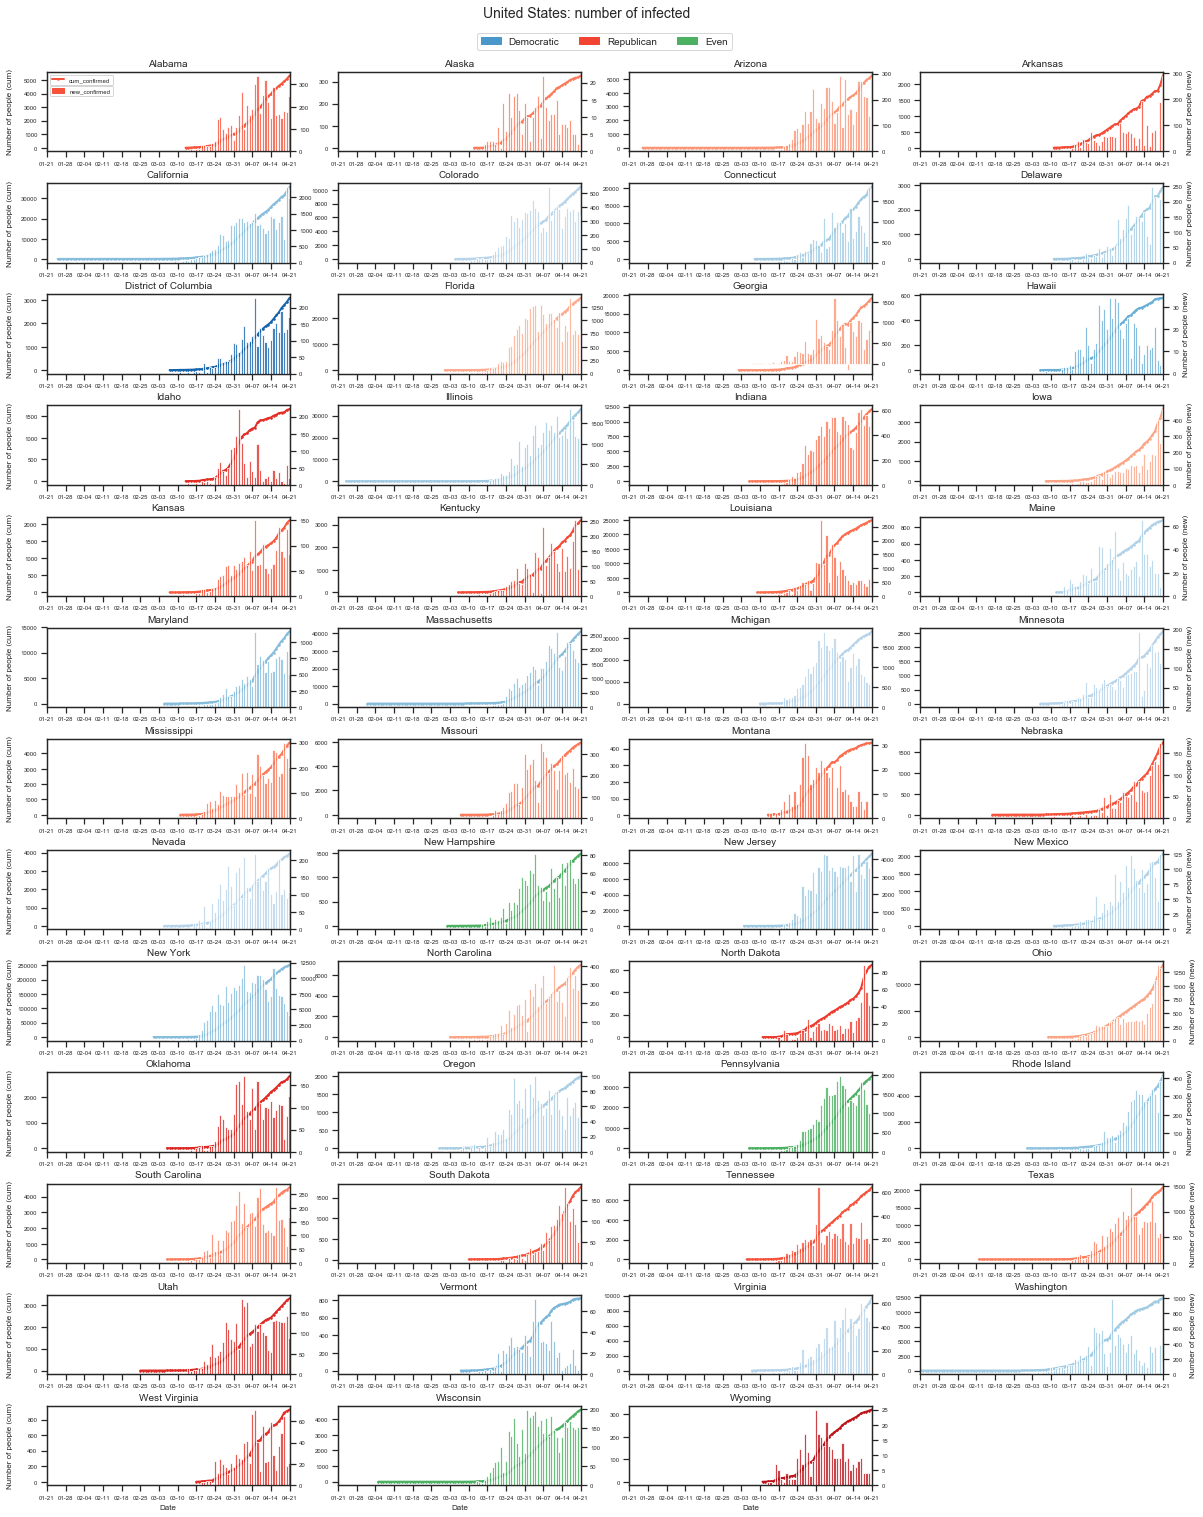

In [183]:
figure_conf_all(df = data_state, names_state = names_state, fsize = (10, 2), ncol = 4, ms = 1.5, fs = 10, logy = False, 
                title = 'United States: number of infected', country = 'US', pvi = True)

In [185]:
# State level map
def figure_map(df, update_date_tr, title = None, country = 'US', cmap = 'Reds'):
    df = df.copy()
    df = df[df['state_name'].isin(names_state)]
    data_single = df[df['update_date'] == update_date_tr]
    locations = [names_state_short_dict[name] for name in names_state]
    values = [data_single[data_single['state_name'] == item]['cum_confirmed'].tolist()[0] for item in names_state]
    values_log = [np.log10(temp) for temp in values]
    palette = plt.get_cmap(cmap)
    cs = [[0, 'rgb(250, 250, 250)'], 
             [0.15, '#AEDADE'], 
             [0.3, '#F9F6D3'],  
             [0.45, '#F5D1BE'], 
             [0.6, '#EAA2A4'], 
             [0.75, '#E385A9'], 
             [1, '#BA77B4']]
    
    fig = go.Figure(data = go.Choropleth(
        locations = locations, # Spatial coordinates
        z = values, # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = cs,             
        marker_line_color = 'white',
        colorbar_title = "Number of infected",
    ))
    
    fig = go.Figure(data = go.Choropleth(
        locations = locations, # Spatial coordinates
        z = values_log, # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = cs,
        marker_line_color = 'white',
        colorbar_title = "Number of infected",
        colorbar=dict(
        tickvals=[1, 2, 3, 4, 5],
        ticktext=["0.01k", "0.1k", "1k", "10k", "100k"],
    )
    ))

    fig.update_layout(
        title_text = title + '<br>' + 'Date: ' + update_date_tr.strftime("%d %B, %Y") + 
        '<br>' + 'Number of infected: ' + str(np.sum(values)),
        geo = dict(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'),
            showlakes = True, # lakes
            lakecolor='rgb(255, 255, 255)'),
    )

    fig.show()
    fig.write_image(_Figure_PATH_ + country + '_map.png')

In [186]:
date_tr = max(data_state['update_date'])
figure_map(data_state, date_tr, title = 'United States', country = 'US', cmap = 'Reds')

In [187]:
# A very comprehensive rose figure
def figure_conf_rose(df, names_state, update_date_tr, title = 'United States', country = 'US', percentage = False):

    df = df.copy()
    df = df[df['update_date'] == update_date_tr]
    df = df[df['state_name'].isin(names_state)]

    bars = [df[df['state_name'] == state]['cum_confirmed'].tolist()[0] for state in names_state]

    df = pd.DataFrame({'state_name': names_state, 'value': bars})
    df.sort_values(by = 'value', ascending = False, inplace = True)

    v = df['state_name'].values.tolist()
    d = df['value'].values.tolist()

    d_D = [d[i] for i, name in enumerate(v) if df_state_pvi[df_state_pvi['state_name'] == name]['partisan'].tolist()[0] == 'D']
    d_R = [d[i] for i, name in enumerate(v) if df_state_pvi[df_state_pvi['state_name'] == name]['partisan'].tolist()[0] == 'R']
    d_Even = [d[i] for i, name in enumerate(v) if df_state_pvi[df_state_pvi['state_name'] == name]['partisan'].tolist()[0] == 'Even']
    d_None = [d[i] for i, name in enumerate(v) if df_state_pvi[df_state_pvi['state_name'] == name]['partisan'].tolist()[0] == 'None']

    palette_D = plt.get_cmap('Blues')
    palette_R = plt.get_cmap('Reds')
    palette_Even = plt.get_cmap('Greens')
    #palette_None = plt.get_cmap('Purples')

    color_series_inner = [rgb2hex(palette_D(0.6)), rgb2hex(palette_R(0.6)), rgb2hex(palette_Even(0.6))]
    color_series = color_series_inner + [rgb2hex(color_pvi(df_state_pvi, state)) for state in v]

    inner_x_data = ['Democratic', 'Republican', 'Even']
    inner_y_data = [np.sum(d_D), np.sum(d_R), np.sum(d_Even)]
    inner_x_data = [item + ': ' + str(inner_y_data[i]) for i, item in enumerate(inner_x_data)]
    inner_y_data = [round(item*100/np.sum(d), 2) for item in inner_y_data]
    inner_data_pair = [list(z) for z in zip(inner_x_data, inner_y_data)]

    v = [names_state_short_dict[item] for item in v]

    v = [item + ': ' + str(d[i]) for i, item in enumerate(v)]

    d = [round(np.sqrt(temp),2) for temp in d] ######## rescale data by taking the square root ########

    pie = Pie(init_opts = opts.InitOpts(width='800px', height='800px'))

    pie.set_colors(color_series)

    fn = """
        function(params) {
            if(params.name.includes('Republican'))
                return '\\n\\n\\n' + params.name.substring(0, 10) + ' : ' + params.value + '%';
            if(params.name.includes('Even'))
                return '\\n\\n\\n\\n\\n\\n' + params.name.substring(0, 4) + ' : ' + params.value + '%';
            if(params.name.includes('None'))
                return '\\n\\n\\n\\n\\n\\n\\n\\n\\n' + params.name.substring(0, 4) + ' : ' + params.value + '%';
            return params.name.substring(0, 10) + ' : ' + params.value + '%';
        }
        """
    def new_label_opts():
        return opts.LabelOpts(formatter = JsCode(fn), font_size = 16, font_weight = 'bold', 
                              position = "center", vertical_align = 'top')
    pie.add(
            series_name = "national",
            data_pair = inner_data_pair,
            radius = ["35%", "45%"], # radius=["50%", "70%"],
            center = ["63%", "65%"],
            label_opts = new_label_opts(),
        )

    fn = """
        function(params) {
            return params.name.substring(0, 2);
        }
        """
    def new_label_opts():
        return opts.LabelOpts(formatter = JsCode(fn), font_size = 12, font_weight = 'bold',
                              position = "inside", vertical_align = 'bottom')
    pie.add("state", [list(z) for z in zip(v, d)],
            radius = ["55%", "125%"], # radius = ["80%", "110%"],
            center = ["63%", "65%"],
            rosetype = "area",
            label_opts = new_label_opts(), # is_show = True, rotate = 'tangent',
            )

    pie.set_global_opts(title_opts = opts.TitleOpts(title = title,subtitle = update_date_tr.strftime("%d %B, %Y"),
                                                title_textstyle_opts = opts.TextStyleOpts(font_size = 22),
                                                subtitle_textstyle_opts = opts.TextStyleOpts(font_size = 18)),
                         legend_opts = opts.LegendOpts(is_show = True, type_ = "plain",  
                                                       textstyle_opts = opts.TextStyleOpts(font_size = 12),
                                                       pos_top = "8%", pos_left = "1%", orient = "vertical"))


    make_snapshot(snapshot, pie.render("US_rose.html"),
                              _Figure_PATH_ + country + "_rose.png")

In [188]:
date_tr = max(data_state['update_date'])
figure_conf_rose(data_state, names_state, date_tr, 
                title = "United States: number of infected", country = 'US', percentage = False)

In [189]:
# Plot the confirmed cases for every county in a given state
def figure_conf_state(df, fsize = (5, 3), ncol = 4, ms = 2, fs = 10, logy = False, 
                      title = None, country = 'US', state = 'New Hampshire', cmap = 'viridis'):
    
    sns.set_style("ticks")
    palette = plt.get_cmap(cmap)
    palette = ['#AEDADE', '#F9F6D3', '#F5D1BE', '#EAA2A4', '#E385A9','#BA77B4'] # adaptive and live
    df_with = df[df['state_name'] == state].copy()
    df = df[df['state_name'] == state].copy()
    df = df[df['county_name']!='Unknown']
    df = df.reset_index(drop=True)
    names_county = sorted(set(df['county_name']))
    m = len(names_county)
    
    df_rank = df[df['update_date'] == max(df['update_date'])]
    df_rank = df_rank.reset_index(drop=True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    
    
    for i, county in enumerate(names_county):
        
        ix = np.unravel_index(i, axes.shape)
        
        plot_df = df[df['county_name'] == county]
        plot_df = plot_df.reset_index(drop=True)
        
        #if plot_df.shape[0] > 1:
        c = palette[int(rank_list.index(i)/m*len(palette))]
        axes[ix].plot(plot_df['update_date'], plot_df['cum_confirmed'], 
                      linewidth = 2, marker = 'o', ms = ms, 
                      color = c, label = (lambda x: None if x > 0 else 'cum_confirmed')(i)) # 
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel("Date", fontsize = fs - 2)
        if i % ncol == 0:
            axes[ix].set_ylabel("Number of people (cum)", fontsize = fs - 2)
        if i == 0:
            axes[ix].legend(loc = 'upper left', fancybox = True, fontsize = fs - 2)
        axes[ix].set_title(county + ': ' + str(plot_df['cum_confirmed'].tolist()[-1]), fontsize = fs)
        
    fig.align_ylabels(axes[:, 0])    
    
    for i, county in enumerate(names_county):   
        ix = np.unravel_index(i, axes.shape)
        plot_df = df[df['county_name'] == county].groupby('update_date').agg('sum')
        #if i not in empty_list:
        ax11 = axes[ix].twinx()
        ax11.grid(False) # hide grid lines
        c = palette[int(rank_list.index(i)/m*len(palette))]
        ax11.bar(x = plot_df.index, height = plot_df['new_confirmed'],
                 color = c, alpha = 1,
                 label = (lambda x: None if x > 0 else 'new_confirmed')(i))
        daily_patch = mpatches.Patch(color = c, label='new_confirmed')
        if i == 0:
            ax11.legend(handles=[daily_patch], loc='upper left', bbox_to_anchor=(0, 0.86), fancybox=True, fontsize = fs - 2)
        if i % ncol == ncol - 1:
            ax11.set_ylabel('Number of people (new)', fontsize = fs - 2)
        ax11.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

        axes[ix].set_xlim(min(df.update_date), max(df.update_date))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    df_with = df_with.groupby(['update_date'])['cum_confirmed'].apply(lambda x : x.sum()).reset_index()       
    fig.suptitle(title + ': ' + str(df_with['cum_confirmed'].tolist()[-1]), fontsize = fs + 2, y = 0.93)
    
    
    fig.savefig(_Figure_PATH_ + country + '_' + state.replace(" ", "_") + '_conf.png', dpi = 400, bbox_inches='tight')

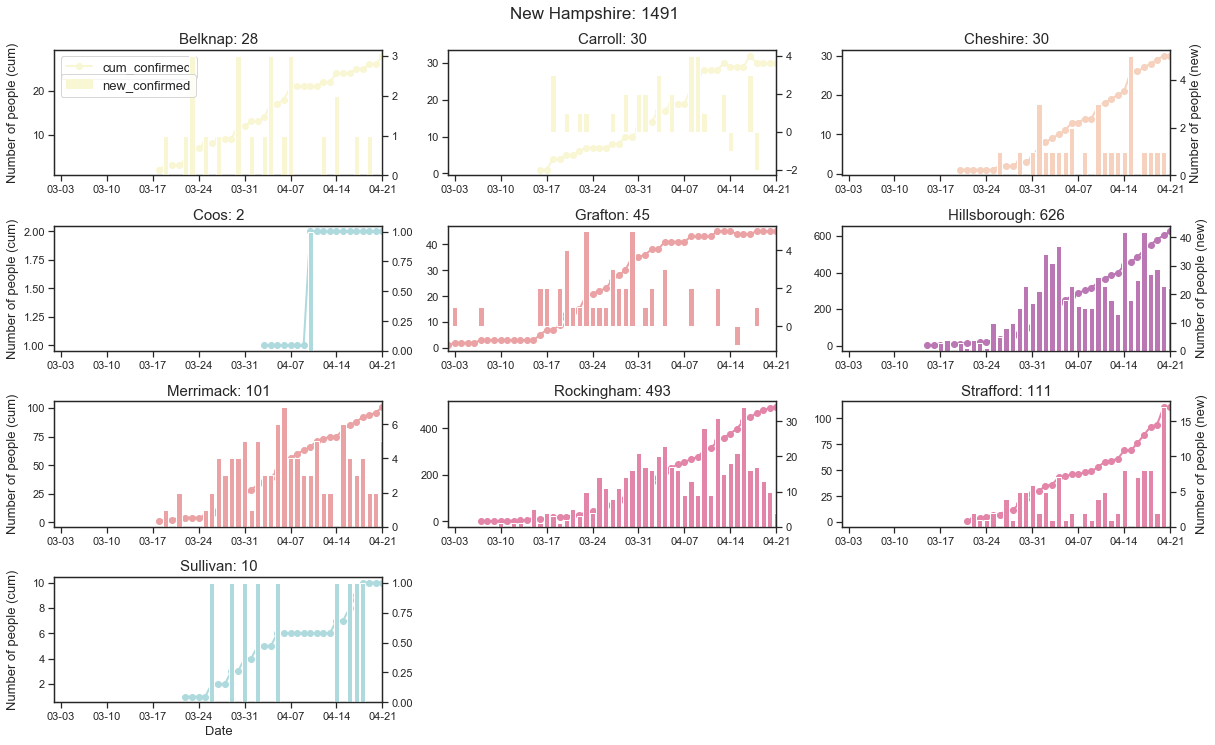

In [190]:
# Our home: Dartmouth College \in Hanover \in Grafton \in New Hampshire
state = 'New Hampshire'
figure_conf_state(df = data_county, fsize = (10, 3), ncol = 3, ms = 6, fs = 15, logy = False, 
                      title = state, country = 'US', state = state, cmap = 'bone')

In [191]:
# plot the confirmed cases for the top 6 counties of every state in a given area
def figure_conf_state_all(df, names_state, fsize = (10,5), ncol = 2, ms = 6, fs = 18, logy = False, 
                    title = None, country = 'US'):
    
    sns.set_style("ticks")
    palette = ['#AEDADE', '#F9F6D3', '#F5D1BE', '#EAA2A4', '#E385A9','#BA77B4']
    
    m = len(names_state)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    palette.reverse()       
    for i, state in enumerate(names_state):
        
        ix = np.unravel_index(i, axes.shape)
        
        plot_df = df[df['state_name'] == state]
        plot_df = plot_df.reset_index(drop = True)
        
        data_single = df[(df['state_name'] == state) & (df['update_date'] == max(df['update_date']))]
        # the 6 counties with the highest numbers of infected 
        county_selected = data_single[data_single['county_name']!= 'Unknown'].sort_values(by = 'cum_confirmed')['county_name'].tail(6).tolist()                                                       
        county_selected.reverse() 
        
        for j, name in enumerate(county_selected):
            
            c = palette[j]
            plot_df_single = plot_df[plot_df['county_name'] == name]
            axes[ix].plot(plot_df_single['update_date'], plot_df_single['cum_confirmed'],
                    linewidth = 3, marker = 'o', ms = ms, color = c, label = name) 
            
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Number of infected', fontsize = fs - 2)
        
        handles, labels = axes[ix].get_legend_handles_labels()
        
        def flip(items, ncol):
            return itertools.chain(*[items[i::ncol] for i in range(ncol)])
        
        axes[ix].legend(flip(handles, 3), flip(labels, 3), loc='upper center', ncol = 3, fancybox=True, fontsize = fs - 4)
        
    
        axes[ix].set_title(state + ': ' + str(np.sum(data_single['cum_confirmed'])), fontsize = fs)
        axes[ix].set_xlim(min(df[df['state_name'].isin(names_state)].update_date), max(df[df['state_name'].isin(names_state)].update_date))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    fig.align_ylabels(axes[:, 0])
    fig.suptitle(title, fontsize = fs + 4, y = 0.94)

    fig.savefig(_Figure_PATH_ + country + '_new_england_conf.png', dpi = 400, bbox_inches='tight')

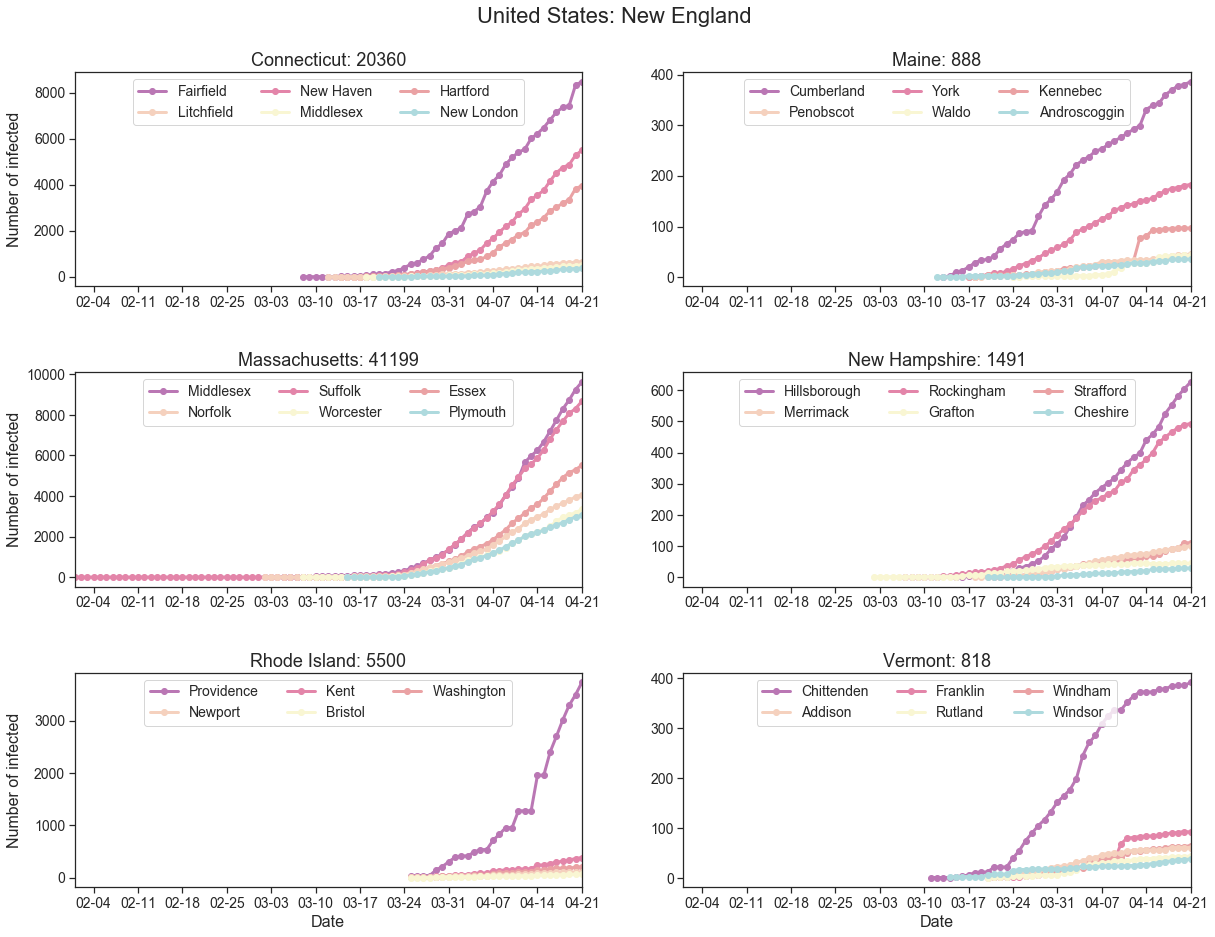

In [192]:
names_state_selected = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont']
figure_conf_state_all(data_county, names_state_selected, fsize = (10,5), ncol = 2, ms = 6, fs = 18, logy = False, 
                    title = 'United States: New England', country = 'US')

In [193]:
# County level map
def figure_map_state(df, update_date_tr, title = None, country = 'US', cmap = 'viridis'):
    
    df = df.copy()
    df.at[df.index[df['county_name'] == 'Kansas City'].tolist(), 'fips'] = 293800
    df.at[df.index[data_county['county_name'] == 'New York City'].tolist(), 'fips'] = 36061
    df = df[df['county_name']!='Unknown'].copy()
    df = df[df['state_name'].isin(names_state)]
    data_single = df[df['update_date'] == update_date_tr]
    names_county = sorted(set(data_single['county_name']))
    fips = [data_single[data_single['county_name'] == item]['fips'].tolist()[0] for item in names_county]
    values = [data_single[data_single['county_name'] == item]['cum_confirmed'].tolist()[0] for item in names_county]
    
    palette = plt.get_cmap(cmap)
    colorscale = [rgb2hex(palette(i/10)) for i in range(0, 12)]
    endpts = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
    fig = ff.create_choropleth(
        fips=fips, 
        values=values,
        show_state_data=False,
        binning_endpoints=endpts,
        colorscale=colorscale,
        show_hover=True, centroid_marker={'opacity': 0},
        county_outline={'color': '#ffffff', 'width': 0.2},
        state_outline={'color': '#ffffff','width': 5},
        asp = 3.2, 
        title = title + '<br>' + 'Date: ' + update_date_tr.strftime("%d %B, %Y"),
        )
    fig.layout.template = None
    fig.update_layout(
    title = {
        'y':0.95,
        'x':0,
        'xanchor': 'left',
        'yanchor': 'top'},
    margin = dict(l = 0, r = 0, t = 60, b = 0),
    
    legend = {'y': 0.9, 'title': {'text': 'number of infected'}},
    )
    fig.show()
    fig.write_image(_Figure_PATH_ + country + '_map_state.png')

In [194]:
date_tr = max(data_county['update_date'])
figure_map_state(data_county, date_tr, title = 'United States', country = 'US', cmap = 'YlOrRd')

/Users/xingruchen/anaconda3/lib/python3.7/site-packages/plotly/figure_factory/_county_choropleth.py:845: UserWarning:

Unrecognized FIPS Values

Whoops! It looks like you are trying to pass at least one FIPS value that is not in our shapefile of FIPS and data for the counties. Your choropleth will still show up but these counties cannot be shown.
Unrecognized FIPS are: [293800]



In [174]:
def figure_SP(df, df_SP, update_date_initial, fsize = (12,5), ms = 6, fs = 16, title = None, country = 'US'):
    
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    df = df[df['update_date'] >= update_date_initial]
    df_SP = df_SP[df_SP['update_date'] >= update_date_initial]
    df_SP = df_SP.reset_index(drop = True)
    df_nation = df.groupby(['update_date'])['new_confirmed'].apply(lambda x : x.sum()).reset_index()
    fig = plt.figure(figsize = fsize)
    ax = plt.subplot(111)
    sns.set_style('ticks')
    ax.plot(df_nation['update_date'], df_nation['new_confirmed'], 
            linewidth = 2, marker = 'o', ms = ms, color = palette[0], label = 'COVID-19')
    
    ax.set_xlabel('Date', fontsize = fs - 2)
    ax.set_ylabel('Number of infected (new)', fontsize = fs - 2)
    
    ax.legend(loc = 'upper left', fontsize = fs - 2, bbox_to_anchor=(0.0, 1), fancybox=True)
    
    ax_twin = ax.twinx()
    ax_twin.plot(df_SP['update_date'], df_SP['close'], 
            linewidth = 2, marker = 'o', ms = ms, color = palette[3], label = 'S&P 500')
    
    ax_twin.set_ylabel('Index', fontsize = fs - 2)
    
    ax_twin.legend(loc = 'upper right', fontsize = fs - 2, bbox_to_anchor=(1, 1), fancybox=True)
    #ax_twin.set_ylim(min(df_SP['close']), max(df_SP['close']))
    
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

    fig.suptitle(title + ': ' + 'Correlation between Infection and the S & P 500 index', fontsize = fs + 2, y = 0.95)
    
    fig.savefig(_Figure_PATH_ + country + '_correlation.png', dpi = 400, bbox_inches='tight')

In [175]:
def figure_stock(df, stock_name, title_name, update_date_initial, fsize = (12,5), ms = 6, fs = 16, title = None, country = 'US'):
    
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    df = df[df['update_date'] >= update_date_initial]
    
    df_nation = df.groupby(['update_date'])['new_confirmed'].apply(lambda x : x.sum()).reset_index()
    fig = plt.figure(figsize = fsize)
    ax = plt.subplot(111)
    sns.set_style('ticks')
    ax.plot(df_nation['update_date'], df_nation['new_confirmed'], 
            linewidth = 2, marker = 'o', ms = ms, color = palette[0], label = 'COVID-19')
    
    ax.set_xlabel('Date', fontsize = fs - 2)
    ax.set_ylabel('Number of infected (new)', fontsize = fs - 2)
    
    ax.legend(loc = 'upper left', fontsize = fs - 2, bbox_to_anchor=(0.0, 1), fancybox=True)
    
    ax_twin = ax.twinx()
    
    data_stock = load_STOCK_raw(stock_name)
    data_stock = data_stock[data_stock['update_date'] >= update_date_initial]
    data_stock = data_stock.reset_index(drop = True)
    ax_twin.plot(data_stock['update_date'], data_stock['close'], 
                 linewidth = 2, marker = 'o', ms = ms, color = palette[3], label = title_name)
    
    ax_twin.set_ylabel('Price', fontsize = fs - 2)
    
    ax_twin.legend(loc = 'upper right', fontsize = fs - 2, bbox_to_anchor=(1, 1), fancybox=True)
    #ax_twin.set_ylim(min(df_SP['close']), max(df_SP['close']))
    
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

    fig.suptitle(title + ': ' + 'Correlation between Infection and the stock price of ' + title_name, fontsize = fs + 2, y = 0.95)
    
    fig.savefig(_Figure_PATH_ + country + '_correlation_' + stock_name + '.png', dpi = 400, bbox_inches='tight')

In [176]:
# S&P 500 index
data_SP = load_SP_raw()

Data date range:  1927-12-30 to 2020-04-22
Number of rows in raw data:  23186


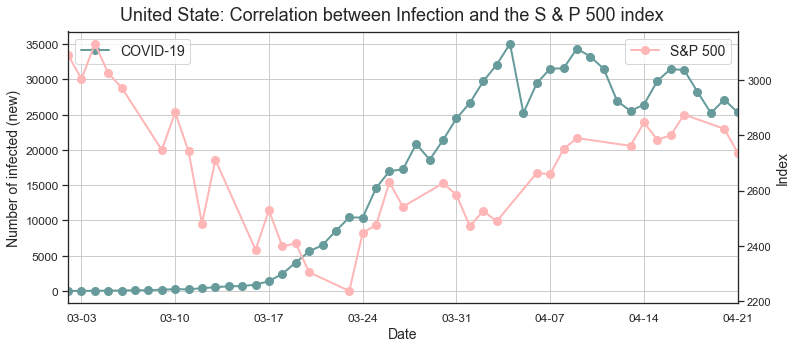

In [177]:
date_initial = datetime.date(int(2020),int(3),int(2))
figure_SP(data_state, data_SP, date_initial, fsize = (12,5), ms = 8, fs = 16, title = 'United State', country = 'US')

In [178]:
#stock_name = 'ZM'
#title_name = 'Zoom'
#figure_stock(data_state, stock_name, title_name, date_initial, fsize = (12,5), ms = 8, fs = 16, title = 'United States', country = 'US')

In [179]:
def figure_stock_list(df, stock_name_list, title_name_list, update_date_initial, 
                      fsize = (12,5), ncol = 2, ms = 6, fs = 16, title = None, country = 'US'):
    
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    df = df[df['update_date'] >= update_date_initial]
    
    df_nation = df.groupby(['update_date'])['new_confirmed'].apply(lambda x : x.sum()).reset_index()
    
    m = len(stock_name_list)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
            
    for i, stock_name in enumerate(stock_name_list):
        
        ix = np.unravel_index(i, axes.shape)
        ax = axes[ix]
        ax.plot(df_nation['update_date'], df_nation['new_confirmed'], 
                linewidth = 2, marker = 'o', ms = ms, color = palette[0], label = 'COVID-19')
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            ax.set_xlabel('Date', fontsize = fs - 2)
        if i % ncol == 0:
            ax.set_ylabel('Number of infected (new)', fontsize = fs - 2)
        
        ax.set_title(title_name_list[i], fontsize = fs)
        
        ax.legend(loc = 'upper left', fontsize = fs - 2, bbox_to_anchor=(0.0, 1), fancybox=True)
    
        ax_twin = ax.twinx()
    
        data_stock = load_STOCK_raw(stock_name)
        data_stock = data_stock[data_stock['update_date'] >= update_date_initial]
        data_stock = data_stock.reset_index(drop = True)
        ax_twin.plot(data_stock['update_date'], data_stock['close'], 
                     linewidth = 2, marker = 'o', ms = ms, color = palette[i%3 + 1], label = stock_name_list[i])
        
        if i % ncol == ncol - 1:
            ax_twin.set_ylabel('Price', fontsize = fs - 2)
    
        ax_twin.legend(loc = 'upper right', fontsize = fs - 2, bbox_to_anchor=(1, 1), fancybox=True)
    
    
        ax.set_xlim(min(df.update_date), max(df.update_date))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

    fig.suptitle(title + ': ' + 'correlation between Infection and the stock market', fontsize = fs + 2, y = 0.9)
    
    fig.savefig(_Figure_PATH_ + country + '_correlation_sm.png', dpi = 400, bbox_inches='tight')

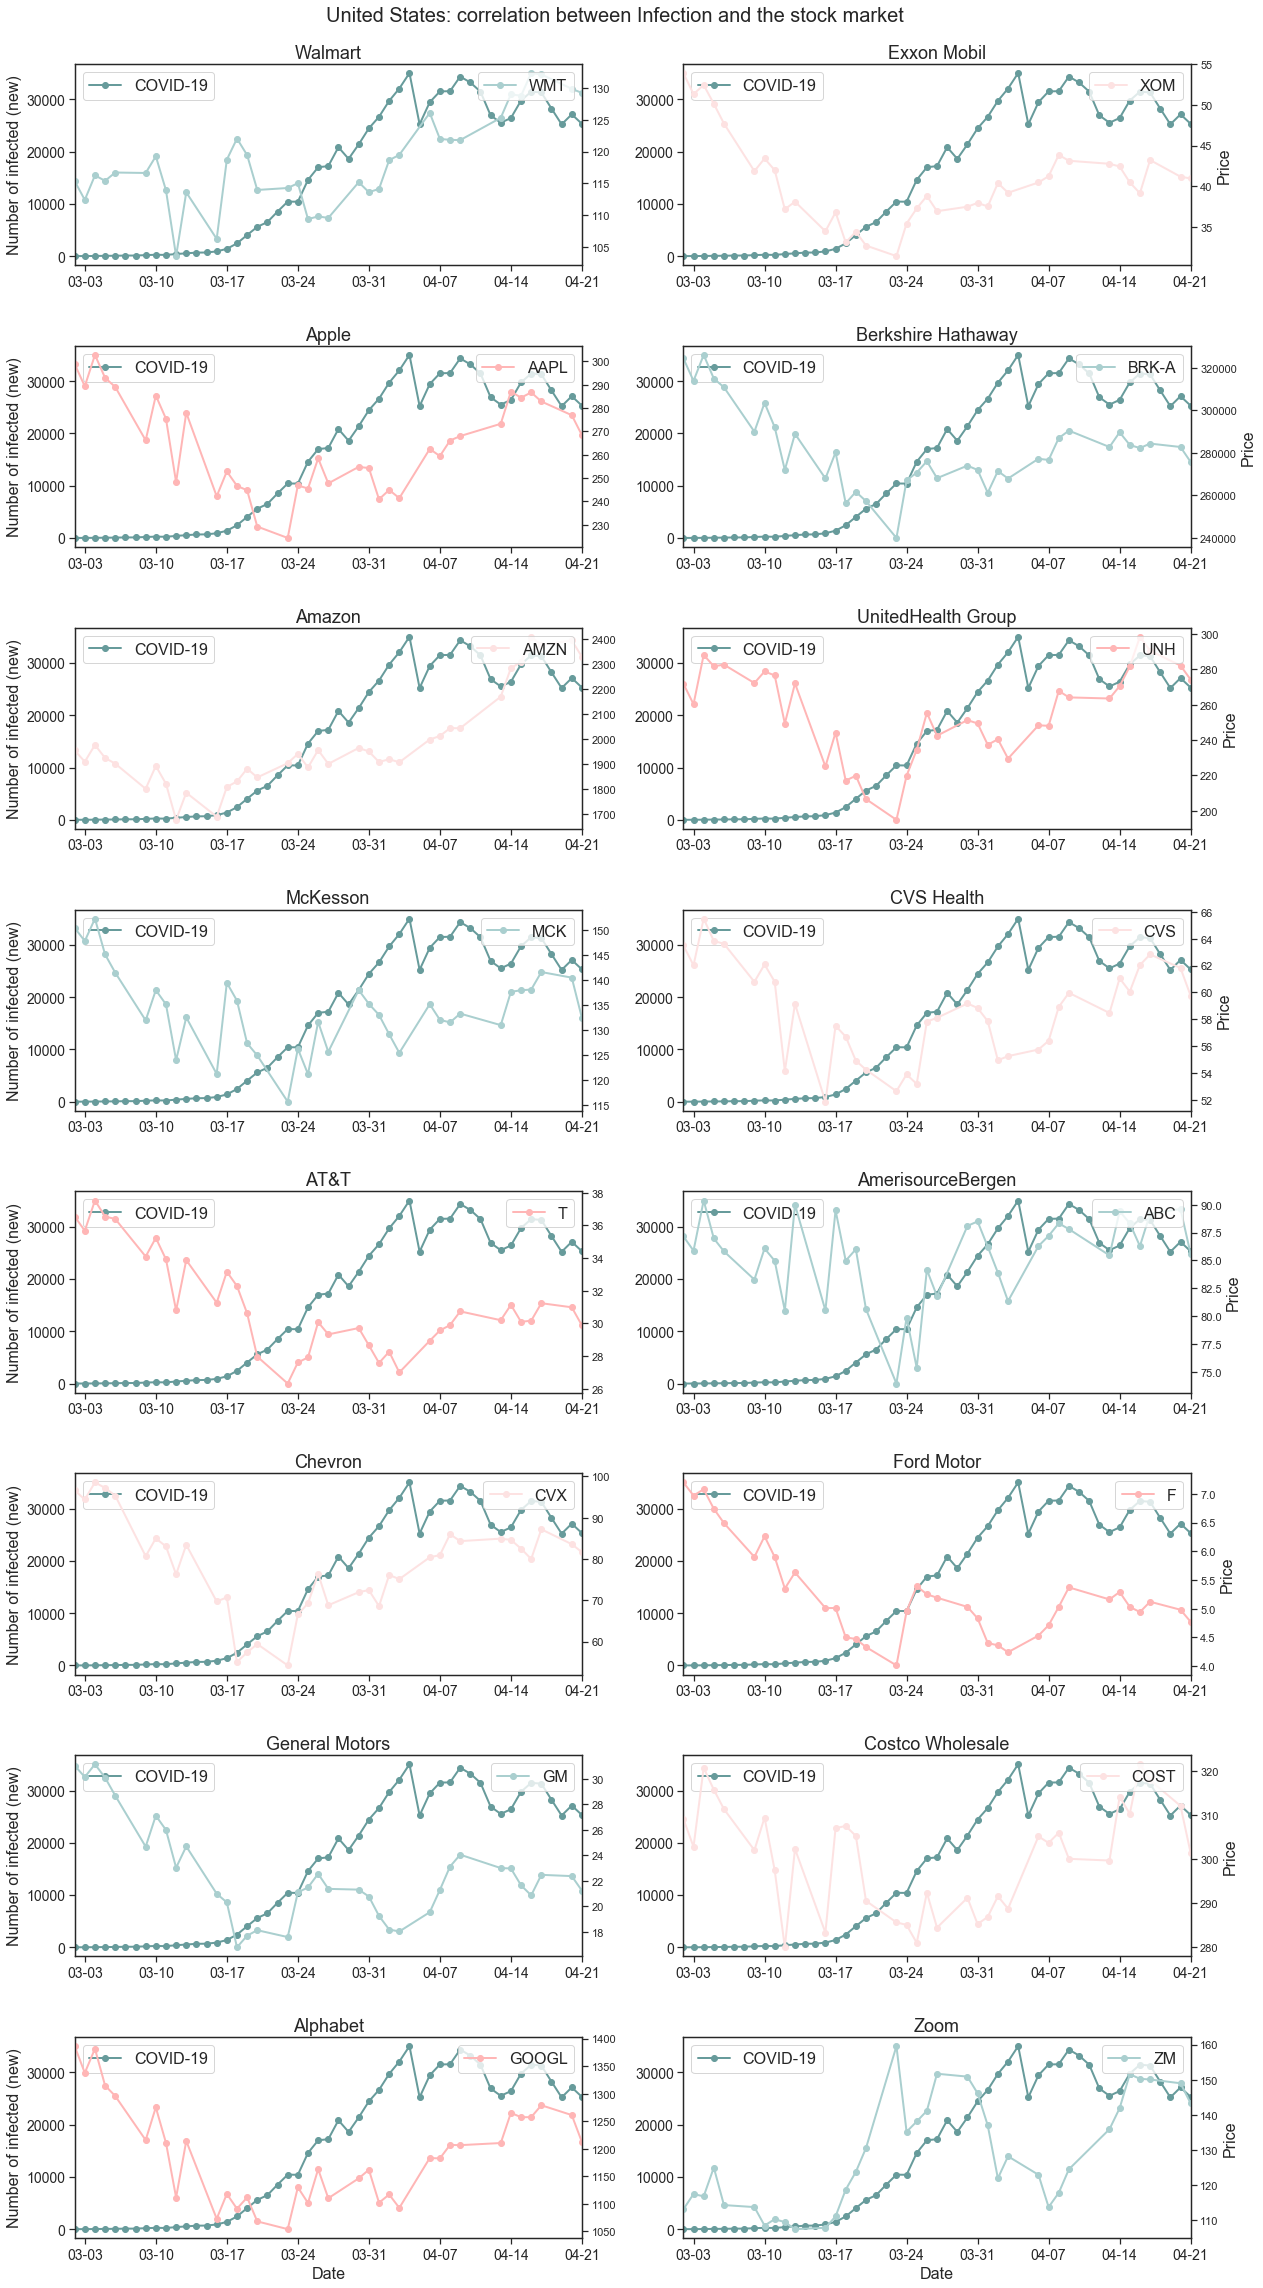

In [180]:
stock_name_list = ['WMT', 'XOM', 'AAPL', 'BRK-A', 'AMZN', 'UNH', 'MCK', 'CVS',
                  'T', 'ABC', 'CVX', 'F', 'GM', 'COST', 'GOOGL', 'ZM']
title_name_list = ['Walmart', 'Exxon Mobil', 'Apple', 'Berkshire Hathaway',
                   'Amazon', 'UnitedHealth Group', 'McKesson', 'CVS Health',
                   'AT&T', 'AmerisourceBergen', 'Chevron', 'Ford Motor', 
                   'General Motors', 'Costco Wholesale', 'Alphabet', 'Zoom']
date_initial = datetime.date(int(2020),int(3),int(2))
figure_stock_list(data_state, stock_name_list, title_name_list, 
                  date_initial, fsize = (10,5), ncol = 2, ms = 6, fs = 18,
                  title = 'United States', country = 'US')